In [1]:
# download hotel locations in Naples

# import libraries
import requests # library to handle requests
# from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import folium # map rendering library
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

print('All packages successfully imported!')

# Foursquare login credentials
CLIENT_ID = 'JKXB1NZHLEIDGDDJCWLAFW34C2MO2U4INCTU5DP2XYWDGPMQ' # Foursquare ID
CLIENT_SECRET = 'S4JNYT15YBGXGKLBGOBDQEXNS5DAD1U41OQ3K3N23JZTH02Q' # Foursquare Secret
VERSION = '20200516' #  API version

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

All packages successfully imported!
My credentails:
CLIENT_ID: JKXB1NZHLEIDGDDJCWLAFW34C2MO2U4INCTU5DP2XYWDGPMQ
CLIENT_SECRET:S4JNYT15YBGXGKLBGOBDQEXNS5DAD1U41OQ3K3N23JZTH02Q


In [2]:
# set the url parameters

near = 'Naples, IT'
categoryId = '4bf58dd8d48988d1fa931735' # hotels 

url = 'https://api.foursquare.com/v2/venues/explore?near={}&categoryId={}&client_id={}&client_secret={}&v={}'.format(near, categoryId,
    CLIENT_ID, CLIENT_SECRET, VERSION)

# send the request
results = requests.get(url).json()
n_results = results['response']['totalResults'] #  number of results
n_results

98

In [3]:
# narrow the search

LIMIT = 100

url = 'https://api.foursquare.com/v2/venues/explore?near={}&categoryId={}&client_id={}&client_secret={}&v={}&limit={}'.format(near, categoryId,
    CLIENT_ID, CLIENT_SECRET, VERSION, LIMIT)

# send the request
results = requests.get(url).json()
n_results = results['response']['totalResults'] #  number of results
n_results

98

In [4]:
# check the number of responses
len(results['response']['groups'][0]['items'])

89

In [5]:
# create a data frame with all hotels

hotels = []

for result in results['response']['groups'][0]['items']:
    hotel_name = result['venue']['name']
    hotel_lat = result['venue']['location']['lat']
    hotel_lng = result['venue']['location']['lng']
    hotel = [hotel_name, hotel_lat, hotel_lng]
    hotels.append(hotel)
    
hotels = pd.DataFrame(hotels, columns=['Name', 'Lattitude', 'Longitude'])
hotels.head()

,Name,Lattitude,Longitude
0,Hotel Piazza Bellini,40.850463,14.251416
1,Grand Hotel Vesuvio,40.829892,14.248090
2,Romeo Hotel Naples,40.840612,14.255748
3,Palazzo Decumani,40.848995,14.259077
4,Palazzo Alabardieri,40.834790,14.241711


In [6]:
hotels.shape

(89, 3)

In [7]:
# define a function to get recommended venues

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Hotel Name', 
                  'Hotel Latitude', 
                  'Hotel Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [8]:
# get the recommended venues for each hotel
hotel_venues = getNearbyVenues(names=hotels['Name'], latitudes = hotels['Lattitude'], longitudes = hotels['Longitude'])

In [9]:
# one hot encoding
venues_onehot = pd.get_dummies(hotel_venues[['Venue Category']], prefix='', prefix_sep='')

# add hotel name column back to dataframe
venues_onehot.insert(loc = 0, column = 'Hotel Name', value = hotel_venues['Hotel Name'].values)

venues_onehot.head()

,Hotel Name,Accessories Store,Airport,Aquarium,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,...,Sushi Restaurant,Theater,Toy / Game Store,Trail,Train Station,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Waterfront,Wine Bar,Zoo
0,Hotel Piazza Bellini,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Hotel Piazza Bellini,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Hotel Piazza Bellini,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Hotel Piazza Bellini,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Hotel Piazza Bellini,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# hotel_venues.rename(columns={'Hotel Names':'Hotel Name'},inplace=True)

In [11]:
# compute the number of venues in each category for a given hotel and normalize it by the largest element

summary = venues_onehot.groupby('Hotel Name').sum()
summary = summary.div(summary.max(axis=0)).reset_index()
summary.head()

,Hotel Name,Accessories Store,Airport,Aquarium,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,...,Sushi Restaurant,Theater,Toy / Game Store,Trail,Train Station,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Waterfront,Wine Bar,Zoo
0,Albergo Palazzo Decumani Hotel Naples,0.0,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.666667,0.0
1,American Park Hotel,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.0
2,Apart Hotel Plebiscito,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,...,0.666667,0.0,0.0,0.0,0.0,0.375,0.0,0.0,0.000000,0.0
3,Apatrhotel Plebiscito,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,...,0.666667,0.0,0.0,0.0,0.0,0.375,0.0,0.0,0.000000,0.0
4,B&B Albachiara,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.0


In [12]:
# function to return venues with the highest sccore
def return_most_common_venues(row, num_top_venues):
    
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# display venues with the highest score
num_top_venues = 5
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Hotel Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
hotels_sorted = pd.DataFrame(columns=columns)
hotels_sorted['Hotel Name'] = summary['Hotel Name']

for ind in np.arange(summary.shape[0]):
    hotels_sorted.iloc[ind, 1:] = return_most_common_venues(summary.iloc[ind, :], num_top_venues)

hotels_sorted.head()

,Hotel Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Albergo Palazzo Decumani Hotel Naples,Deli / Bodega,Comic Shop,Fried Chicken Joint,Sandwich Place,Pizza Place
1,American Park Hotel,Nightclub,Hotel,Cupcake Shop,Electronics Store,Donut Shop
2,Apart Hotel Plebiscito,History Museum,Juice Bar,Opera House,Other Great Outdoors,Palace
3,Apatrhotel Plebiscito,History Museum,Speakeasy,Fish Market,Juice Bar,Diner
4,B&B Albachiara,Metro Station,Burger Joint,Soccer Stadium,Supermarket,Coffee Shop


In [13]:
# set number of clusters
kclusters = 7

hotel_clusters = summary.drop('Hotel Name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hotel_clusters)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 3, 3, 1, 3], dtype=int32)

In [14]:
# add clustering labels
# hotels_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
hotels_sorted['Cluster Labels'] = kmeans.labels_

In [15]:
hotels_merged = hotels.merge(hotels_sorted,left_on='Name',right_on='Hotel Name')

In [16]:
hotels_merged.drop(columns='Hotel Name',inplace=True)

In [17]:
# create map
map_clusters = folium.Map(location=[40.85, 14.30], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hotels_merged['Lattitude'], hotels_merged['Longitude'], hotels_merged['Name'], hotels_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [18]:
hotels_merged[hotels_merged['Cluster Labels']==1]

,Name,Lattitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster Labels
3,Palazzo Decumani,40.848995,14.259077,Deli / Bodega,Comic Shop,Fried Chicken Joint,Sandwich Place,Pizza Place,1
5,Albergo Palazzo Decumani Hotel Naples,40.848944,14.259059,Deli / Bodega,Comic Shop,Fried Chicken Joint,Sandwich Place,Pizza Place,1
6,Palazzo Caracciolo Hotel Naples,40.854852,14.261464,Juice Bar,Convenience Store,Theater,Performing Arts Venue,Pizza Place,1
7,Grand Hotel Parker's,40.837170,14.230222,Spanish Restaurant,Burger Joint,Museum,Frozen Yogurt Shop,Japanese Restaurant,1
8,Hotel Paradiso Best Western,40.826196,14.217461,Park,Pier,Cable Car,Restaurant,Scenic Lookout,1
12,Hotel villa,40.815840,14.172076,Department Store,Movie Theater,Light Rail Station,Food,Dessert Shop,1
13,Fly Boutique Hotel,40.847661,14.264785,Food & Drink Shop,Pizza Place,Food,Clothing Store,Plaza,1
15,Hotel Nuvò Napoli,40.817218,14.175760,Concert Hall,Movie Theater,Department Store,Supermarket,Food,1
20,Palazzo Salgar,40.846070,14.264163,Pizza Place,Boat or Ferry,Pier,Clothing Store,Plaza,1
22,Hotel Naples,40.845087,14.257613,Fried Chicken Joint,Sandwich Place,Comic Shop,Deli / Bodega,Road,1


In [19]:
# create a cluster summary

# add the cluster label to the hotel/venues table
# focus on the total number, not the relative frequency
cluster_summary = venues_onehot.merge(hotels_sorted, on="Hotel Name").groupby('Cluster Labels').sum().reset_index()

# get the most common venues for each cluster
# create columns according to number of top venues
columns = ['Cluster Labels']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
clusters_sorted = pd.DataFrame(columns=columns)
clusters_sorted['Cluster Labels'] = cluster_summary['Cluster Labels']

for ind in np.arange(cluster_summary.shape[0]):
    clusters_sorted.iloc[ind, 1:] = return_most_common_venues(cluster_summary.iloc[ind, :], num_top_venues)

clusters_sorted

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,Italian Restaurant,Hotel,Pizza Place,Trattoria/Osteria,Café
1,1,Pizza Place,Hotel,Café,Italian Restaurant,Plaza
2,2,Italian Restaurant,Hotel,Pizza Place,Café,Plaza
3,3,Hotel,Pizza Place,Café,Italian Restaurant,Plaza
4,4,Italian Restaurant,Hotel,Seafood Restaurant,Pizza Place,Castle
5,5,Pizza Place,Italian Restaurant,Cocktail Bar,Plaza,Café
6,6,Italian Restaurant,Café,Plaza,Pizza Place,Historic Site


In [20]:
cluster_summary

,Cluster Labels,Accessories Store,Airport,Aquarium,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,...,Sushi Restaurant,Theater,Toy / Game Store,Trail,Train Station,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Waterfront,Wine Bar,Zoo
0,0,0,0,0,0,16,7,0,0,0,...,3,12,9,3,0,36,0,0,0,0
1,1,1,1,0,1,13,0,2,0,1,...,7,7,0,0,3,15,2,2,9,1
2,2,0,0,0,0,3,9,0,0,0,...,4,5,0,0,0,19,0,0,1,0
3,3,0,0,0,0,2,0,0,4,0,...,0,0,0,0,11,13,0,0,1,0
4,4,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,4,4,0,4,0
5,5,0,0,1,0,2,0,0,0,0,...,5,1,0,0,1,1,0,0,6,0
6,6,0,0,0,4,3,0,0,0,0,...,0,2,0,0,0,1,4,0,4,0


In [21]:
# focus on the largest score in a given cluster
cluster_summary = venues_onehot.merge(hotels_sorted, on="Hotel Name").groupby('Cluster Labels').sum()
cluster_summary = cluster_summary.div(cluster_summary.max(axis=0)).reset_index()

In [22]:
columns = ['Cluster Labels']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
clusters_sorted = pd.DataFrame(columns=columns)
clusters_sorted['Cluster Labels'] = cluster_summary['Cluster Labels']

for ind in np.arange(cluster_summary.shape[0]):
    clusters_sorted.iloc[ind, 1:] = return_most_common_venues(cluster_summary.iloc[ind, :], num_top_venues)

clusters_sorted

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,Bistro,Mediterranean Restaurant,Cupcake Shop,Cosmetics Shop,Pastry Shop
1,1,Zoo,Food Truck,Frozen Yogurt Shop,Furniture / Home Store,Gastropub
2,2,Supermarket,Asian Restaurant,Snack Place,Palace,Opera House
3,3,Castle,Food & Drink Shop,Café,Platform,Dessert Shop
4,4,Garden,Steakhouse,Vegetarian / Vegan Restaurant,Cafeteria,Seafood Restaurant
5,5,Multiplex,Electronics Store,Aquarium,Frozen Yogurt Shop,Cocktail Bar
6,6,Beer Bar,Music School,Music Venue,Pub,Nightclub


In [23]:
# find the optimum value of k
inertia = []
hotel_clusters = summary.drop('Hotel Name', 1)
kvalues = np.arange(20)+1

# run k-means clustering
for k in kvalues:
    kclusters = k+1
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hotel_clusters)
    inertia.append(kmeans.inertia_)

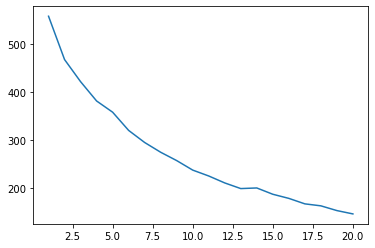

In [24]:
plt.plot(kvalues, inertia)
plt.show()

In [25]:
kvalues

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

In [26]:
inertia[8]

258.0542150940185

In [27]:
# started with k = 4
# let's try k = 9
# clusters 2 & 5 are too similar, 1 & 6
# so let's try k = 8
# cluster 3 & 4 are too similar, so let's try k = 7
# I'm happy with = 7
# best cluster seems to be 6, let's visualize them

map_clusters = folium.Map(location=[40.85, 14.30], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hotels_merged['Lattitude'], hotels_merged['Longitude'], hotels_merged['Name'], hotels_merged['Cluster Labels']):
    if cluster == 6:
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)

map_clusters

In [28]:
hotel_venues

,Hotel Name,Hotel Latitude,Hotel Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Hotel Piazza Bellini,40.850463,14.251416,Libreria Berisio,40.849405,14.251149,Bookstore
1,Hotel Piazza Bellini,40.850463,14.251416,Hotel Piazza Bellini,40.850463,14.251416,Hotel
2,Hotel Piazza Bellini,40.850463,14.251416,Piazza Vincenzo Bellini,40.849843,14.252102,Plaza
3,Hotel Piazza Bellini,40.850463,14.251416,Piazza Dante,40.849016,14.250188,Plaza
4,Hotel Piazza Bellini,40.850463,14.251416,Spazio Nea,40.850178,14.252068,Art Gallery
...,...,...,...,...,...,...,...
3519,Hotel Augustus,40.848831,14.475788,La Delizia,40.849568,14.479686,Ice Cream Shop
3520,Hotel Augustus,40.848831,14.475788,San Michele Food e Drink,40.845935,14.471990,Pizza Place
3521,Rooms Rent Vesuvio Bed & breakfast,40.851483,14.341922,Cirelli Bakery,40.847685,14.339153,Bakery
3522,Rooms Rent Vesuvio Bed & breakfast,40.851483,14.341922,Rooms Rent Vesuvio Bed & breakfast,40.851483,14.341922,Bed & Breakfast


In [30]:
venues_onehot

,Hotel Name,Accessories Store,Airport,Aquarium,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,...,Sushi Restaurant,Theater,Toy / Game Store,Trail,Train Station,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Waterfront,Wine Bar,Zoo
0,Hotel Piazza Bellini,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Hotel Piazza Bellini,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Hotel Piazza Bellini,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Hotel Piazza Bellini,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Hotel Piazza Bellini,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3519,Hotel Augustus,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3520,Hotel Augustus,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3521,Rooms Rent Vesuvio Bed & breakfast,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3522,Rooms Rent Vesuvio Bed & breakfast,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
